# Classification

In [1]:
import os
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader
from pathlib import Path
import torch
import cv2 as cv
from torch.utils.data import Dataset, DataLoader
from torch import nn
from matplotlib import pyplot as plt
from torchvision.models import resnet18
from pytorch_metric_learning.losses import ArcFaceLoss
import lightning
from lightning.pytorch.loggers import TensorBoardLogger
from tqdm import tqdm

## Data

In [2]:
root = Path('data').resolve()
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

train_helper, val_helper = train_helper.train_val_split()
train_helper.size(), val_helper.size()

(2578433, 644609)

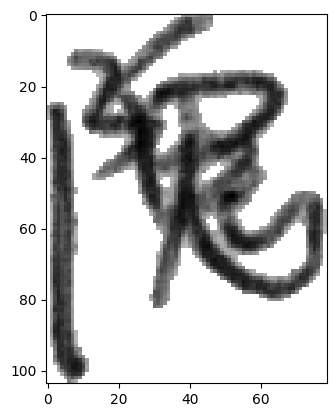

In [3]:
img, label = train_helper.get_item(42)
plt.imshow(img, cmap='gray')

In [4]:
class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper, desired_size=64):
        self.helper = helper
        self.desired_size = desired_size
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)

        old_size = img.shape[:2]
        ratio = float(self.desired_size) / max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        img = cv.resize(img, (new_size[1], new_size[0]))

        width_change = self.desired_size - new_size[1]
        height_change = self.desired_size - new_size[0]
        top, bottom = height_change//2, height_change - (height_change//2)
        left, right = width_change//2, width_change - (width_change//2)

        new_img = cv.copyMakeBorder(img, top, bottom, left, right, cv.BORDER_CONSTANT)

        return torch.FloatTensor((new_img - 127.5) / 255.), label

In [20]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size, num_workers=8, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size, num_workers=8, shuffle=False)

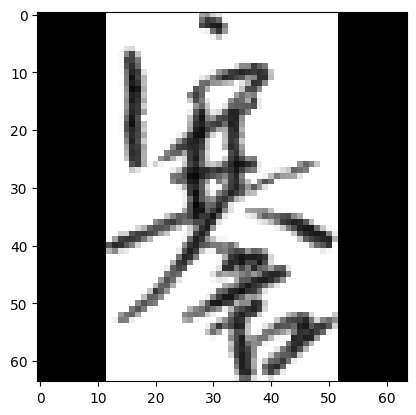

In [21]:
plt.imshow(train_dataset[1][0], cmap='gray')

## Model

In [22]:
class ResNetWrapper(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.net = resnet18(pretrained=True)
        self.net.fc = nn.Linear(self.net.fc.in_features, embedding_size)
    
    def forward(self, x):
        return self.net(x.unsqueeze(1).expand(-1, 3, -1, -1))

In [23]:
class LitClassifier(lightning.LightningModule):
    def __init__(self, model, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)        
        self.log("train_loss", loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        self.log("val_loss", loss)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=1e-3)
        return optimizer

In [9]:
%load_ext tensorboard

In [24]:
num_classes = train_helper.vocabulary.num_classes()
embedding_dim = 1024
model = ResNetWrapper(embedding_dim)
criterion = ArcFaceLoss(num_classes=num_classes, embedding_size=embedding_dim)

lit_model = LitClassifier(model, criterion)
logger = TensorBoardLogger("tb_logs", name="ResNet")
trainer = lightning.Trainer(logger=logger, max_epochs=3)
trainer.fit(model=lit_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/home/semyon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/semyon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params
--------------------------------------------
0 | model     | ResNetWrapper | 11.7 M
1 | criterion | ArcFaceLoss   | 7.5 M 
--

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
%tensorboard --logdir tb_logs

In [25]:
torch.save(model.state_dict(), "Weights/ResNet.pt")
torch.save(lit_model.criterion.state_dict(), "Weights/ArcFace.pt")

## Evaluation

In [26]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=8)

In [27]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
criterion.to(device);

In [28]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = criterion.get_logits(model(X.to(device)))
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

100%|██████████| 380/380 [02:09<00:00,  2.94it/s]


In [29]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [30]:
from course_intro_ocr_t2.evaluate import evaluate

evaluate(gt_path, pred_path)

0.9310503359205072